In [ ]:
!python -m spacy download en_core_web_lg

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm.notebook import tqdm
import spacy

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

from string import punctuation

from sklearn.metrics.pairwise import cosine_similarity
from sklearn import svm

import random
import pickle

#---------------downloading ---------------------
spacy = spacy.load("en_core_web_lg")
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stopWords = stopwords.words('english')

In [ ]:
#SNI dataset:
train_raw_sni = pd.read_json("./drive/MyDrive/ColabData/snli_1.0_train.jsonl",lines = True)
train_raw_sni = train_raw_sni[train_raw_sni.gold_label!='-'][:6633]

#MNLI dataset:
train_raw_mnli = pd.read_json("./drive/MyDrive/ColabData/mnli_train.jsonl",lines = True)
train_raw_mnli = train_raw_mnli[train_raw_mnli.gold_label!='-'][:10000]


#RTE dataset
train_raw_rte3_train = pd.read_xml("./drive/MyDrive/ColabData/rte3_dev.xml")# 800 sample data
train_raw_rte3_train.drop(columns=("length"),inplace = True)
train_raw_rte2_train = pd.read_xml("./drive/MyDrive/ColabData/rte2_dev.xml")# 400 sample data
train_raw_rte2_test = pd.read_xml("./drive/MyDrive/ColabData/rte2_test.xml")# 800 sample data
train_raw_rte1_train = pd.read_xml("./drive/MyDrive/ColabData/rte1_dev.xml")# 567 sample data
train_raw_rte1_test = pd.read_xml("./drive/MyDrive/ColabData/rte1_test.xml")# 800 sample data
train_raw_rte1_train.rename(columns = {"value":"entailment"},inplace = True)
train_raw_rte1_test.rename(columns = {"value":"entailment"},inplace = True)


train_raw = train_raw_rte3_train.append(train_raw_rte2_train,ignore_index=True)
train_raw = train_raw.append(train_raw_rte2_test,ignore_index=True)
train_raw = train_raw.append(train_raw_rte1_train,ignore_index=True)
train_raw = train_raw.append(train_raw_rte1_test,ignore_index=True)




train_raw.loc[ train_raw["entailment"] == "YES",   "entailment" ] = "entailment"
train_raw.loc[ train_raw["entailment"] == True,  "entailment" ] = "entailment"
train_raw.loc[ train_raw["entailment"] == "NO",    "entailment" ] = "other"
train_raw.loc[ train_raw["entailment"] == False, "entailment" ] = "other"

train_raw.rename(columns = {"t":"sentence1","h":"sentence2","entailment":"gold_label"},inplace = True)
train_raw = train_raw.append(train_raw_sni,ignore_index = True)
train_raw = train_raw.append(train_raw_mnli,ignore_index = True)



#test RTE dataset
test_raw_rte3 = pd.read_xml("./drive/MyDrive/ColabData/rte3_test.xml")
test_raw_sni = pd.read_json("./drive/MyDrive/ColabData/snli_1.0_test.jsonl",lines = True)
test_raw_sni = train_raw_sni[train_raw_sni.gold_label!='-'][:2200]

test_raw_rte3.loc[test_raw_rte3["entailment"]=="YES","entailment"] = "entailment"
test_raw_rte3.loc[test_raw_rte3["entailment"]=="NO","entailment"] = "other"
test_raw_rte3.rename(columns = {"t":"sentence1","h":"sentence2","entailment":"gold_label"},inplace = True)

test_raw = test_raw_rte3.append(test_raw_sni,ignore_index = True)



In [ ]:
train = train_raw
train.drop(columns=["id","task","annotator_labels","captionID","pairID","sentence1_binary_parse","sentence1_parse","sentence2_binary_parse","sentence2_parse","genre","promptID"],inplace = True)
train.replace("neutral","other", inplace = True)
train.replace("contradiction","other", inplace = True)
train = train.reset_index()

test = test_raw
test.replace("neutral","other", inplace = True)
test.replace("contradiction","other", inplace = True)

print("len test:",len(test),"len train:",len(train))

len test: 3000 len train: 20000


In [ ]:
train

,index,gold_label,sentence1,sentence2
0,0,entailment,The sale was made to pay Yukos' US$ 27.5 billi...,Baikalfinansgroup was sold to Rosneft.
1,1,other,The sale was made to pay Yukos' US$ 27.5 billi...,Yuganskneftegaz cost US$ 27.5 billion.
2,2,other,Loraine besides participating in Broadway's Dr...,"""Does A Tiger Have A Necktie"" was produced in ..."
3,3,entailment,"""The Extra Girl"" (1923) is a story of a small-...","""The Extra Girl"" was produced by Sennett."
4,4,entailment,A bus collision with a truck in Uganda has res...,30 die in a bus collision in Uganda.
...,...,...,...,...
19995,19995,other,"Because, despite its monopoly power, Microsoft...",Microsoft owns 60 percent of all computer-rela...
19996,19996,other,"'Right,' I mumbled.","'Wrong', I said."
19997,19997,other,Thanks dad.,Thanks Obama.
19998,19998,other,which is good,I don't think that's great


In [ ]:
def normalizedTokenizer(text):
   wnl = WordNetLemmatizer()
   ps = PorterStemmer()
   return [ps.stem(wnl.lemmatize(x)) for x in word_tokenize(text.lower()) if x not in punctuation and x not in stopWords] #

# First approach, cosine-similarity

In [ ]:
def generateBagOfWord(sentences):
  BOW = defaultdict(lambda: defaultdict(lambda: 0))
  corpus = list(enumerate(sentences))
  for i, document in corpus:
    tokens = normalizedTokenizer(document)
    for token in tokens:
        BOW[i][token] += 1
  return BOW

In [ ]:
def predict(T,H,threshold):
  bow = generateBagOfWord([T,H])
  data = (pd.DataFrame(bow).fillna(0, inplace=False).T).values
  similarity = cosine_similarity(data[0].reshape(1, -1),data[1].reshape(1, -1))
  if similarity > threshold:
    return "entailment"
  else:
    return "other"

In [ ]:
def evaluation(threshold):
  tp = fp = fn = tn = 0
  for index in range(len(test)):
    prediction = predict(test.sentence1[index],test.sentence2[index],threshold)
    actualLable = test.gold_label[index]
    if actualLable == "entailment":
      if prediction == "entailment":
        tp +=1
      else:
        fn +=1
    else:
        if prediction == "other":
          tn+=1
        else:
            fp+=1
  return {"Accuracy":round( (tp+tn) / (tp+tn+fp+fn),2),"Percision":round(tp/(tp+fp),2),"Recall":round(tp/(tp+fn),2)}

In [ ]:
threshold = 0.45
#{'Accuracy': 0.66, 'Percision': 0.56, 'Recall': 0.53}
evaluation(threshold)

{'Accuracy': 0.66, 'Percision': 0.56, 'Recall': 0.53}

  0%|          | 0/100 [00:00<?, ?it/s]

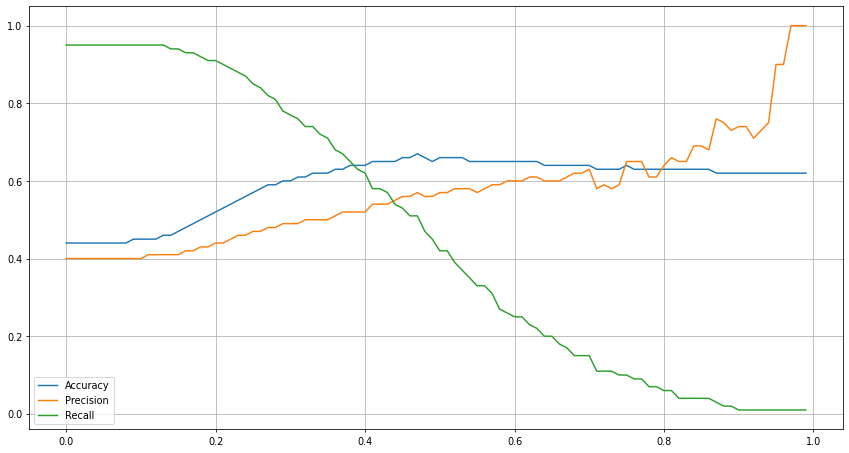

In [ ]:
values = {"threshold":[],"Accuracy":[],"Percision":[],"Recall":[]}
for thresh in tqdm(np.arange(0,1,0.01)):
  measurement = evaluation(thresh)
  values["threshold"].append(thresh)
  values["Recall"].append(measurement["Recall"])
  values["Percision"].append(measurement["Percision"])
  values["Accuracy"].append(measurement["Accuracy"])

plt.figure(figsize =(15,8),dpi = 70)

plt.plot(values["threshold"],values["Accuracy"])
plt.plot(values["threshold"],values["Percision"])
plt.plot(values["threshold"],values["Recall"])
plt.legend(["Accuracy","Precision","Recall"])
plt.grid()
plt.show()

In [ ]:
T = "Tim managed to stop the car"
H = "Tim stopped the car"
H1 = "Tim tried to stop the car"
H2 = "Tim did something to the car"
H3 = "the color of the cor is blue"
H4 = "car is not moving any more"
print(" T->H",predict (T,H,threshold),"correct:entrailment\n","T->H1",predict (T,H1,threshold),"correct:entrailment\n","T->H2",predict (T,H2,threshold),"correct:entrailment\n",
      "T->H3",predict (T,H3,threshold),"correct:other\n","T->H4",predict (T,H4,threshold),"correct:entrailment\n",)


T = "Tim has bought fish tonight"
H = "Tim has spent some money"
H1 = "Tim has bought something"
H2 = "Tim Is relaxed and happy!"
print(" T->H",predict (T,H,threshold),"correct:entrailment\n","T->H1",predict (T,H1,threshold),"correct:entrailment\n","T->H2",predict (T,H2,threshold),"correct:other\n",)


T = "A girl playing a violin along with a group of people"
H = "A girl is playing an instrument."
H1 = "A girl is playing outdoor alone"
H2 = "A girl is playing volleyball with other groups of people"
print(" T->H",predict (T,H,threshold),"correct:entrailment\n","T->H1",predict (T,H1,threshold),"correct:other\n","T->H2",predict (T,H2,threshold),"correct:other\n",)

 T->H entailment correct:entrailment
 T->H1 entailment correct:entrailment
 T->H2 entailment correct:entrailment
 T->H3 other correct:other
 T->H4 other correct:entrailment

 T->H other correct:entrailment
 T->H1 entailment correct:entrailment
 T->H2 other correct:other

 T->H entailment correct:entrailment
 T->H1 other correct:other
 T->H2 entailment correct:other



# Second approach: Cosine Directional Similarity

In [ ]:
def predict(T,H,threshold):
  threshold_one = threshold[0]
  threshold_two = threshold[1]
  threshold_three = threshold[2]
  sentence_one = normalizedTokenizer(T)
  sentence_two = normalizedTokenizer(H)
  c = len([x for x in sentence_one if x in sentence_two])
  cos_T = np.sqrt(c/len(sentence_one))
  cos_H = np.sqrt(c/len(sentence_two))
  cos_HT = np.sqrt( (4*np.power(c,2)) / ( (len(sentence_two)+c) * (len(sentence_one)+c) ) )
  if (cos_HT - cos_T) <= threshold_one and (cos_H - cos_HT) <= threshold_two and max(cos_H,cos_T,cos_HT) >=threshold_three:
    return "entailment"
  else:
    return "other"

In [ ]:
def evaluation(threshold):
  tp = fp = fn = tn = 0
  for index in range(len(test)):
    prediction = predict(test.sentence1[index],test.sentence2[index],threshold)
    actualLable = test.gold_label[index]
    if actualLable == "entailment":
      if prediction == "entailment":
        tp +=1
      else:
        fn +=1
    else:
        if prediction == "other":
          tn+=1
        else:
            fp+=1
  return {"Accuracy":round( (tp+tn) / (tp+tn+fp+fn),2),"Percision":round(tp/(tp+fp),2),"Recall":round(tp/(tp+fn),2)}

In [ ]:
threshold = [0.5,0.7,0.7]
#{'Accuracy': 0.6, 'Percision': 0.49, 'Recall': 0.84}
evaluation(threshold)

{'Accuracy': 0.6, 'Percision': 0.49, 'Recall': 0.84}

In [ ]:
T = "Tim managed to stop the car"
H = "Tim stopped the car"
H1 = "Tim tried to stop the car"
H2 = "Tim did something to the car"
H3 = "the color of the cor is blue"
H4 = "car is not moving any more"
print(" T->H",predict (T,H,threshold),"correct:entrailment\n","T->H1",predict (T,H1,threshold),"correct:entrailment\n","T->H2",predict (T,H2,threshold),"correct:entrailment\n",
      "T->H3",predict (T,H3,threshold),"correct:other\n","T->H4",predict (T,H4,threshold),"correct:entrailment\n",)


T = "Tim has bought fish tonight"
H = "Tim has spent money"
H1 = "Tim has bought something"
H2 = "Tim Is relaxed and happy!"
print(" T->H",predict (T,H,threshold),"correct:entrailment\n","T->H1",predict (T,H1,threshold),"correct:entrailment\n","T->H2",predict (T,H2,threshold),"correct:other\n",)


T = "A girl playing a violin along with a group of people"
H = "A girl is playing an instrument."
H1 = "A girl is playing outdoor alone"
H2 = "A girl is playing volleyball with other groups of people"
print(" T->H",predict (T,H,threshold),"correct:entrailment\n","T->H1",predict (T,H1,threshold),"correct:other\n","T->H2",predict (T,H2,threshold),"correct:other\n",)

 T->H entailment correct:entrailment
 T->H1 entailment correct:entrailment
 T->H2 entailment correct:entrailment
 T->H3 other correct:other
 T->H4 entailment correct:entrailment

 T->H other correct:entrailment
 T->H1 entailment correct:entrailment
 T->H2 other correct:other

 T->H entailment correct:entrailment
 T->H1 entailment correct:other
 T->H2 entailment correct:other



# Third Approach, Modified Lev. Distance

In [ ]:
def editDistance(a,b):
  remove_cost = 3
  insert_cost = 3
  swap_cost = 2
  substitude_cost = 5
  cost = 0
  if len(b) < len(a):
    difference = (len(a) - len(b))
    cost += (remove_cost * difference)
    a = a[:-difference]
  elif len(b) > len(a):
    difference = (len(b) - len(a))
    cost += (insert_cost * difference)
    a = a + b[-difference:]
  for index in range(len(b)):
    if a[index] != b[index]:
      if index != len(b)-1 and index != 0:
         if a[index + 1] == b[index]:
           cost += swap_cost
           a = a[:index]+a[index+1]+a[index]+a[index+2:]
         elif a[index - 1] == b[index]:
           cost += swap_cost
           a = a[:index-1]+a[index-1]+a[index]+a[index+1:]
      else:
        cost += substitude_cost
        a = a[:index]+b[index]+a[index+1:]
  return cost


def predict(T,H):
  sentence_one = "".join(normalizedTokenizer(T))
  sentence_two = "".join(normalizedTokenizer(H))
  ed_TH = editDistance(sentence_one,sentence_two)
  ed_HT = editDistance(sentence_two,sentence_one)
  if ed_TH < ed_HT:
    return "entailment"
  else:
    return "other"

In [ ]:
def evaluation():
  tp = fp = fn = tn = 0
  for index in range(len(test)):
    prediction = predict(test.sentence1[index],test.sentence2[index])
    actualLable = test.gold_label[index]
    if actualLable == "entailment":
      if prediction == "entailment":
        tp +=1
      else:
        fn +=1
    else:
        if prediction == "other":
          tn+=1
        else:
            fp+=1
  return {"Accuracy":round( (tp+tn) / (tp+tn+fp+fn),2),"Percision":round(tp/(tp+fp),2),"Recall":round(tp/(tp+fn),2)}

In [ ]:
#{'Accuracy': 0.57, 'Percision': 0.21, 'Recall': 0.05}
evaluation()

{'Accuracy': 0.57, 'Percision': 0.21, 'Recall': 0.05}

In [ ]:
T = "Tim managed to stop the car"
H = "Tim stopped the car"
H1 = "Tim tried to stop the car"
H2 = "Tim did something to the car"
H3 = "the color of the cor is blue"
H4 = "car is not moving any more"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:entrailment\n","T->H2",predict (T,H2),"correct:entrailment\n",
      "T->H3",predict (T,H3),"correct:other\n","T->H4",predict (T,H4),"correct:entrailment\n",)


T = "Tim has bought fish tonight"
H = "Tim has spent money"
H1 = "Tim has bought something"
H2 = "Tim Is relaxed and happy!"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:entrailment\n","T->H2",predict (T,H2),"correct:other\n",)


T = "A girl playing a violin along with a group of people"
H = "A girl is playing an instrument."
H1 = "A girl is playing outdoor alone"
H2 = "A girl is playing volleyball with other groups of people"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:other\n","T->H2",predict (T,H2),"correct:other\n",)

 T->H other correct:entrailment
 T->H1 other correct:entrailment
 T->H2 other correct:entrailment
 T->H3 other correct:other
 T->H4 other correct:entrailment

 T->H other correct:entrailment
 T->H1 other correct:entrailment
 T->H2 other correct:other

 T->H other correct:entrailment
 T->H1 entailment correct:other
 T->H2 other correct:other



# Fourth Approach, SVM and GaussianNB

In [ ]:
def tagsDifference(T,H):
  counter = 0
  sentence_one = spacy(T)
  sentence_two = spacy(H)
  tags_T = []
  tags_H = []
  for token in sentence_one:
    tags_T.append(token.tag_)
  for token in sentence_two:
    tags_H.append(token.tag_)  
  for tag in tags_H:
    if tag in tags_T:
      tags_T.remove(tag)
      counter +=1
  return counter / len(tags_H)



def tagsSimilarity(T,H):
  
  sentence_one = spacy(T)
  sentence_two = spacy(H)
  tags_T = []
  tags_H = []
  for token in sentence_one:
    tags_T.append(token.tag_)
  for token in sentence_two:
    tags_H.append(token.tag_)  

  bow = generateBagOfWord([" ".join(tags_T)," ".join(tags_H)])
  data = (pd.DataFrame(bow).fillna(0, inplace=False).T).values
  similarity = cosine_similarity(data[0].reshape(1, -1),data[1].reshape(1, -1)).flatten()[0]
  return similarity

In [ ]:
def generateData(T,H):
  vector = []
  bow = generateBagOfWord([T,H])
  data = (pd.DataFrame(bow).fillna(0, inplace=False).T).values
  similarity = cosine_similarity(data[0].reshape(1, -1),data[1].reshape(1, -1)).flatten()[0]

  sentence_one = normalizedTokenizer(T)
  sentence_two = normalizedTokenizer(H)
  c = len([x for x in sentence_one if x in sentence_two])
  cos_T = np.sqrt(c/len(sentence_one))
  cos_H = np.sqrt(c/len(sentence_two))
  cos_HT = np.sqrt( (4*np.power(c,2)) / ( (len(sentence_two)+c) * (len(sentence_one)+c) ) )

  sentence_one = "".join(normalizedTokenizer(T))
  sentence_two = "".join(normalizedTokenizer(H))
  ed_TH = editDistance(sentence_one,sentence_two)
  ed_HT = editDistance(sentence_two,sentence_one)

  vector.append(similarity)
  vector.append(cos_T)
  vector.append(cos_H)
  vector.append(cos_HT)
  vector.append(ed_HT - ed_TH)
  vector.append(tagsDifference(T,H))
  vector.append(tagsSimilarity(T,H))
  vector.append(np.sqrt(tagsSimilarity(T,H)))
  return vector


def getX_Y(dataset):
  x = []
  y = []
  for index in tqdm(range(len(dataset))):
    try:
      x.append(generateData(dataset.sentence1[index], dataset.sentence2[index]))
      if dataset.gold_label[index] == "entailment":
        y.append(1)
      else:
        y.append(0)
    except:
      pass
  return x,y

In [ ]:
X,Y = getX_Y(train)
X_test,Y_test = getX_Y(test)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
#---------------------Store prepared Data--------------------------------
with open('./drive/MyDrive/ColabData/X_train.data', 'wb') as f:
        pickle.dump(X, f)

with open('./drive/MyDrive/ColabData/Y_train.data', 'wb') as f:
        pickle.dump(Y, f)

with open('./drive/MyDrive/ColabData/X_test.data', 'wb') as f:
        pickle.dump(X_test, f)

with open('./drive/MyDrive/ColabData/Y_test.data', 'wb') as f:
        pickle.dump(Y_test, f)

In [ ]:
#---------------------Load prepared Data--------------------------------
with open('./drive/MyDrive/ColabData/X_train.data', 'rb') as f:
        X = pickle.load(f)

with open('./drive/MyDrive/ColabData/Y_train.data', 'rb') as f:
        Y = pickle.load(f)

with open('./drive/MyDrive/ColabData/X_test.data', 'rb') as f:
        X_test = pickle.load(f)

with open('./drive/MyDrive/ColabData/Y_test.data', 'rb') as f:
        Y_test = pickle.load(f)

**SVM**

In [ ]:
def clf_model():
  clf = svm.SVC(kernel = 'rbf', C = 200, gamma = 200)
  clf.fit(X,Y)
  return clf

model_SVM = clf_model()

In [ ]:
def predict(T,H):
  test = [generateData(T,H)]
  if model_SVM.predict(test)[0] == 1:
      return "entailment"
  else:
      return "other"

def evaluate():
  tp = fp = fn = tn = 0
  for index in tqdm(range(len(test))):

    prediction =model_SVM.predict( [X_test[index]] )[0]
    actualLable = Y_test[index]
    if actualLable == 1:
      if prediction == 1:
        tp +=1
      else:
        fn +=1
    else:
        if prediction == 0:
          tn+=1
        else:
            fp+=1
  return {"Accuracy":round( (tp+tn) / (tp+tn+fp+fn),2),"Percision":round(tp/(tp+fp),2),"Recall":round(tp/(tp+fn),2)}

In [ ]:
#{'Accuracy': 0.83, 'Percision': 0.8, 'Recall': 0.75}  C = 10 gamma = 200 and 1 epoch
evaluate() 

  0%|          | 0/3000 [00:00<?, ?it/s]

{'Accuracy': 0.83, 'Percision': 0.8, 'Recall': 0.75}

In [ ]:
T = "Tim managed to stop the car"
H = "Tim stopped the car"
H1 = "Tim tried to stop the car"
H2 = "Tim did something to the car"
H3 = "the color of the cor is blue"
H4 = "car is not moving any more"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:entrailment\n","T->H2",predict (T,H2),"correct:entrailment\n",
      "T->H3",predict (T,H3),"correct:other\n","T->H4",predict (T,H4),"correct:entrailment\n",)


T = "Tim has bought fish tonight"
H = "Tim has spent money tonight"
H1 = "Tim has bought something"
H2 = "Tim Is relaxed and happy!"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:entrailment\n","T->H2",predict (T,H2),"correct:other\n",)


T = "A girl playing a violin along with a group of people"
H = "A girl is playing an instrument."
H1 = "A girl is playing outdoor alone"
H2 = "A girl is playing volleyball with other groups of people"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:other\n","T->H2",predict (T,H2),"correct:other\n",)

 T->H entailment correct:entrailment
 T->H1 other correct:entrailment
 T->H2 entailment correct:entrailment
 T->H3 other correct:other
 T->H4 other correct:entrailment

 T->H entailment correct:entrailment
 T->H1 entailment correct:entrailment
 T->H2 other correct:other

 T->H other correct:entrailment
 T->H1 other correct:other
 T->H2 other correct:other



**GaussianNB Classifier**

In [ ]:
def clf_model():
  clf = GaussianNB(var_smoothing= 1e-3)
  clf.fit(X,Y)
  return clf

model_NB = clf_model()

In [ ]:
def predict(T,H):
  test = [generateData(T,H)]
  if model_NB.predict(test)[0] == 1:
      return "entailment"
  else:
      return "other"

def evaluate():
  tp = fp = fn = tn = 0
  for index in tqdm(range(len(test))):
    prediction = model_NB.predict( [X_test[index]] )[0]
    actualLable = Y_test[index]
    if actualLable == 1:
      if prediction == 1:
        tp +=1
      else:
        fn +=1
    else:
        if prediction == 0:
          tn+=1
        else:
            fp+=1
  return {"Accuracy":round( (tp+tn) / (tp+tn+fp+fn),2),"Percision":round(tp/(tp+fp),2),"Recall":round(tp/(tp+fn),2)}

In [ ]:
#{'Accuracy': 0.66, 'Percision': 0.54, 'Recall': 0.64}
evaluate()

  0%|          | 0/3000 [00:00<?, ?it/s]

{'Accuracy': 0.66, 'Percision': 0.54, 'Recall': 0.64}

In [ ]:
T = "Tim managed to stop the car"
H = "Tim stopped the car"
H1 = "Tim tried to stop the car"
H2 = "Tim did something to the car"
H3 = "the color of the cor is blue"
H4 = "car is not moving any more"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:entrailment\n","T->H2",predict (T,H2),"correct:entrailment\n",
      "T->H3",predict (T,H3),"correct:other\n","T->H4",predict (T,H4),"correct:entrailment\n",)


T = "Tim has bought fish tonight"
H = "Tim has spent money"
H1 = "Tim has bought something"
H2 = "Tim Is relaxed and happy!"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:entrailment\n","T->H2",predict (T,H2),"correct:other\n",)


T = "A girl playing a violin along with a group of people"
H = "A girl is playing an instrument."
H1 = "A girl is playing outdoor alone"
H2 = "A girl is playing volleyball with other groups of people"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:other\n","T->H2",predict (T,H2),"correct:other\n",)

 T->H entailment correct:entrailment
 T->H1 entailment correct:entrailment
 T->H2 entailment correct:entrailment
 T->H3 other correct:other
 T->H4 other correct:entrailment

 T->H other correct:entrailment
 T->H1 entailment correct:entrailment
 T->H2 other correct:other

 T->H entailment correct:entrailment
 T->H1 other correct:other
 T->H2 entailment correct:other



**Decision Tree classifier**

In [ ]:
def clf_model():
  clf = DecisionTreeClassifier()
  clf.fit(X,Y)
  return clf

model_DTC = clf_model()

In [ ]:
def predict(T,H):
  test = [generateData(T,H)]
  if model_DTC.predict(test)[0] == 1:
      return "entailment"
  else:
      return "other"


def evaluate():
  tp = fp = fn = tn = 0
  for index in tqdm(range(len(test))):
    prediction = model_DTC.predict( [X_test[index]] )[0]
    actualLable = Y_test[index]
    if actualLable == 1:
      if prediction == 1:
        tp +=1
      else:
        fn +=1
    else:
        if prediction == 0:
          tn+=1
        else:
            fp+=1
  return {"Accuracy":round( (tp+tn) / (tp+tn+fp+fn),2),"Percision":round(tp/(tp+fp),2),"Recall":round(tp/(tp+fn),2)}

In [ ]:
#{'Accuracy': 0.87, 'Percision': 0.85, 'Recall': 0.81}
evaluate() 

  0%|          | 0/3000 [00:00<?, ?it/s]

{'Accuracy': 0.87, 'Percision': 0.85, 'Recall': 0.81}

In [ ]:
T = "Tim managed to stop the car"
H = "Tim stopped the car"
H1 = "Tim tried to stop the car"
H2 = "Tim did something to the car"
H3 = "the color of the cor is blue"
H4 = "car is not moving any more"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:entrailment\n","T->H2",predict (T,H2),"correct:entrailment\n",
      "T->H3",predict (T,H3),"correct:other\n","T->H4",predict (T,H4),"correct:entrailment\n",)


T = "Tim has bought fish tonight"
H = "Tim has spent money"
H1 = "Tim has bought something"
H2 = "Tim Is relaxed and happy!"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:entrailment\n","T->H2",predict (T,H2),"correct:other\n",)


T = "A girl playing a violin along with a group of people"
H = "A girl is playing an instrument."
H1 = "A girl is playing outdoor alone"
H2 = "A girl is playing volleyball with other groups of people"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:other\n","T->H2",predict (T,H2),"correct:other\n",)

 T->H entailment correct:entrailment
 T->H1 other correct:entrailment
 T->H2 entailment correct:entrailment
 T->H3 entailment correct:other
 T->H4 other correct:entrailment

 T->H other correct:entrailment
 T->H1 other correct:entrailment
 T->H2 entailment correct:other

 T->H other correct:entrailment
 T->H1 entailment correct:other
 T->H2 other correct:other



**AdaBoost Classifier**

In [ ]:
def clf_model():
  clf = AdaBoostClassifier(n_estimators=10)
  clf.fit(X,Y)
  return clf

model_Ada = clf_model()

In [ ]:
def predict(T,H):
  test = [generateData(T,H)]
  if model_Ada.predict(test)[0] == 1:
      return "entailment"
  else:
      return "other"

def evaluate():
  tp = fp = fn = tn = 0
  for index in tqdm(range(len(test))):
    prediction = model_Ada.predict( [X_test[index]] )[0]
    actualLable = Y_test[index]
    if actualLable == 1:
      if prediction == 1:
        tp +=1
      else:
        fn +=1
    else:
        if prediction == 0:
          tn+=1
        else:
            fp+=1
  return {"Accuracy":round( (tp+tn) / (tp+tn+fp+fn),2),"Percision":round(tp/(tp+fp),2),"Recall":round(tp/(tp+fn),2)}

In [ ]:
#{'Accuracy': 0.71, 'Percision': 0.67, 'Recall': 0.45}
evaluate() 

  0%|          | 0/3000 [00:00<?, ?it/s]

{'Accuracy': 0.71, 'Percision': 0.67, 'Recall': 0.45}

In [ ]:
T = "Tim managed to stop the car"
H = "Tim stopped the car"
H1 = "Tim tried to stop the car"
H2 = "Tim did something to the car"
H3 = "the color of the cor is blue"
H4 = "car is not moving any more"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:entrailment\n","T->H2",predict (T,H2),"correct:entrailment\n",
      "T->H3",predict (T,H3),"correct:other\n","T->H4",predict (T,H4),"correct:entrailment\n",)


T = "Tim has bought fish tonight"
H = "Tim has spent money"
H1 = "Tim has bought something"
H2 = "Tim Is relaxed and happy!"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:entrailment\n","T->H2",predict (T,H2),"correct:other\n",)


T = "A girl playing a violin along with a group of people"
H = "A girl is playing an instrument."
H1 = "A girl is playing outdoor alone"
H2 = "A girl is playing volleyball with other groups of people"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:other\n","T->H2",predict (T,H2),"correct:other\n",)

 T->H entailment correct:entrailment
 T->H1 entailment correct:entrailment
 T->H2 other correct:entrailment
 T->H3 other correct:other
 T->H4 other correct:entrailment

 T->H other correct:entrailment
 T->H1 entailment correct:entrailment
 T->H2 other correct:other

 T->H other correct:entrailment
 T->H1 other correct:other
 T->H2 other correct:other



**MLP Classifier**

In [ ]:
def clf_model():
  clf = MLPClassifier(random_state=50)
  clf.fit(X,Y)
  return clf

model_MLP = clf_model()

In [ ]:
def predict(T,H):
  test = [generateData(T,H)]
  if model_MLP.predict(test)[0] == 1:
      return "entailment"
  else:
      return "other"

def evaluate():
  tp = fp = fn = tn = 0
  for index in tqdm(range(len(test))):
    prediction = model_MLP.predict( [X_test[index]] )[0]
    actualLable = Y_test[index]
    if actualLable == 1:
      if prediction == 1:
        tp +=1
      else:
        fn +=1
    else:
        if prediction == 0:
          tn+=1
        else:
            fp+=1
  return {"Accuracy":round( (tp+tn) / (tp+tn+fp+fn),2),"Percision":round(tp/(tp+fp),2),"Recall":round(tp/(tp+fn),2)}

In [ ]:
#{'Accuracy': 0.71, 'Percision': 0.68, 'Recall': 0.43}
evaluate()

  0%|          | 0/3000 [00:00<?, ?it/s]

{'Accuracy': 0.71, 'Percision': 0.68, 'Recall': 0.43}

In [ ]:
T = "Tim managed to stop the car"
H = "Tim stopped the car"
H1 = "Tim tried to stop the car"
H2 = "Tim did something to the car"
H3 = "the color of the cor is blue"
H4 = "car is not moving any more"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:entrailment\n","T->H2",predict (T,H2),"correct:entrailment\n",
      "T->H3",predict (T,H3),"correct:other\n","T->H4",predict (T,H4),"correct:entrailment\n",)


T = "Tim has bought fish tonight"
H = "Tim has spent money"
H1 = "Tim has bought something"
H2 = "Tim Is relaxed and happy!"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:entrailment\n","T->H2",predict (T,H2),"correct:other\n",)


T = "A girl playing a violin along with a group of people"
H = "A girl is playing an instrument."
H1 = "A girl is playing outdoor alone"
H2 = "A girl is playing volleyball with other groups of people"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:other\n","T->H2",predict (T,H2),"correct:other\n",)

 T->H entailment correct:entrailment
 T->H1 entailment correct:entrailment
 T->H2 other correct:entrailment
 T->H3 other correct:other
 T->H4 other correct:entrailment

 T->H other correct:entrailment
 T->H1 other correct:entrailment
 T->H2 other correct:other

 T->H other correct:entrailment
 T->H1 other correct:other
 T->H2 other correct:other



**Combine**

In [ ]:
def predict(T,H):
  test = [generateData(T,H)]
  prediction = []
  models = [model_SVM, model_MLP, model_Ada, model_DTC, model_NB]
  for model in models:
    prediction.append(model.predict(test)[0])
  number_of_entailments = len(list(filter(lambda x: x==1,prediction)))
  number_of_other = len(list(filter(lambda x: x==0,prediction)))
  if number_of_entailments>number_of_other:
      return "entailment"
  else:
      return "other"




def evaluate():
  tp = fp = fn = tn = 0
  models = [model_SVM, model_MLP, model_Ada, model_DTC, model_NB]

  for index in tqdm(range(len(test))):
    sentence = [X_test[index]]
    prediction = []
    for model in models:
      prediction.append(model.predict(sentence)[0])
      if model is model_DTC:
         prediction.append(model.predict(sentence)[0])
         if model.predict(sentence)[0] == 1:
          prediction.append(model.predict(sentence)[0])
          prediction.append(model.predict(sentence)[0])
          prediction.append(model.predict(sentence)[0])
          

    number_of_entailments = len(list(filter(lambda x: x==1,prediction)))
    number_of_other = len(list(filter(lambda x: x==0,prediction)))
    if number_of_entailments>number_of_other:
        prediction = 1
    else:
        prediction = 0
    actualLable = Y_test[index]
    if actualLable == 1:
      if prediction == 1:
        tp +=1
      else:
        fn +=1
    else:
        if prediction == 0:
          tn+=1
        else:
            fp+=1
  return {"Accuracy":round( (tp+tn) / (tp+tn+fp+fn),2),"Percision":round(tp/(tp+fp),2),"Recall":round(tp/(tp+fn),2)}

In [ ]:
#{'Accuracy': 0.88, 'Percision': 0.83, 'Recall': 0.84}
evaluate()

  0%|          | 0/3000 [00:00<?, ?it/s]

{'Accuracy': 0.88, 'Percision': 0.83, 'Recall': 0.84}

In [ ]:
T = "Tim managed to stop the car"
H = "Tim stopped the car"
H1 = "Tim tried to stop the car"
H2 = "Tim did something to the car"
H3 = "the color of the cor is blue"
H4 = "car is not moving any more"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:entrailment\n","T->H2",predict (T,H2),"correct:entrailment\n",
      "T->H3",predict (T,H3),"correct:other\n","T->H4",predict (T,H4),"correct:entrailment\n",)


T = "Tim has bought fish tonight"
H = "Tim has spent money tonight"
H1 = "Tim has bought something"
H2 = "Tim Is relaxed and happy!"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:entrailment\n","T->H2",predict (T,H2),"correct:other\n",)


T = "A girl playing a violin along with a group of people"
H = "A girl is playing an instrument."
H1 = "A girl is playing outdoor alone"
H2 = "A girl is playing volleyball with other groups of people"
print(" T->H",predict (T,H),"correct:entrailment\n","T->H1",predict (T,H1),"correct:other\n","T->H2",predict (T,H2),"correct:other\n",)

 T->H entailment correct:entrailment
 T->H1 entailment correct:entrailment
 T->H2 entailment correct:entrailment
 T->H3 other correct:other
 T->H4 other correct:entrailment

 T->H entailment correct:entrailment
 T->H1 entailment correct:entrailment
 T->H2 other correct:other

 T->H other correct:entrailment
 T->H1 other correct:other
 T->H2 other correct:other

